### Step 1: Load CSV and Filter Five Major Banks

We begin by loading the full complaint dataset and filtering only the following five banks, which have more balanced label distributions for 'Company response to consumer':

- BANK OF AMERICA, NATIONAL ASSOCIATION  
- JPMORGAN CHASE & CO.  
- CAPITAL ONE FINANCIAL CORPORATION  
- CITIBANK, N.A.  
- WELLS FARGO & COMPANY

In [1]:
import pandas as pd
import numpy as np

# Load the full complaints dataset
file_path = '/Users/chungwei/Library/CloudStorage/OneDrive-Personal/06_Study/UW MSIM/00_Terms/03_spring/526 Building LLM/Project/wk6/complaints_selected_five_banks.csv'
df = pd.read_csv(file_path)

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Define the 5-bank list
target_banks = [
    'BANK OF AMERICA, NATIONAL ASSOCIATION',
    'JPMORGAN CHASE & CO.',
    'CAPITAL ONE FINANCIAL CORPORATION',
    'CITIBANK, N.A.',
    'WELLS FARGO & COMPANY'
]

# Filter only the selected banks
df_banks = df[df['company'].isin(target_banks)].copy()

# Check results
print("Filtered dataset shape:", df_banks.shape)
print("Unique banks:", df_banks['company'].unique())

Filtered dataset shape: (675408, 18)
Unique banks: ['CITIBANK, N.A.' 'JPMORGAN CHASE & CO.' 'WELLS FARGO & COMPANY'
 'CAPITAL ONE FINANCIAL CORPORATION'
 'BANK OF AMERICA, NATIONAL ASSOCIATION']


### Step 2: Initial Quality Check

We check for missing values and label distribution to ensure our model will be learning from clean, relevant data. This also helps assess balance between response types.

In [2]:
# Check null values
print("Missing values per column:")
print(df_banks.isnull().sum())

# Check label distribution
print("\nDistribution of 'company_response_to_consumer':")
print(df_banks['company_response_to_consumer'].value_counts())

Missing values per column:
date_received                        0
product                              0
sub-product                      54471
issue                                3
sub-issue                       258374
consumer_complaint_narrative    425646
company_public_response         370236
company                              0
state                            10698
zip_code                          7268
tags                            578298
consumer_consent_provided?      255276
submitted_via                        0
date_sent_to_company                 0
company_response_to_consumer         2
timely_response?                     0
consumer_disputed?              458011
complaint_id                         0
dtype: int64

Distribution of 'company_response_to_consumer':
company_response_to_consumer
Closed with explanation            496590
Closed with monetary relief         83535
Closed with non-monetary relief     72526
Closed without relief               11842
In progress 

### Step 3: Count and Ratio of Complaint Narratives by Company and Response Type

We compute the following for each (`company`, `company_response_to_consumer`) group:
- Total complaint count
- Number of complaints with a narrative
- Ratio of narrative presence
- Percentage that each response type makes up within a company

We also visualize the result with company-wise spacing to improve readability.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and calculate counts
grouped = (
    df_banks
    .groupby(['company', 'company_response_to_consumer'])
    .agg(
        total_complaints=('company', 'count'),
        narrative_count=('consumer_complaint_narrative', lambda x: x.notna().sum())
    )
    .reset_index()
)

# Compute ratios
grouped['narrative_ratio'] = (grouped['narrative_count'] / grouped['total_complaints']).round(2)

# Compute within-company response label share
total_by_company = grouped.groupby('company')['total_complaints'].transform('sum')
grouped['response_ratio_within_company'] = (grouped['total_complaints'] / total_by_company).round(2)

# Sort for plotting
grouped = grouped.sort_values(by=['company', 'total_complaints'], ascending=[True, False])

# Display the summary
display(grouped)

,company,company_response_to_consumer,total_complaints,narrative_count,narrative_ratio,response_ratio_within_company
1,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with explanation,103301,31336,0.30,0.67
2,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with monetary relief,27688,12193,0.44,0.18
3,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with non-monetary relief,15893,4145,0.26,0.10
5,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed without relief,4527,0,0.00,0.03
6,"BANK OF AMERICA, NATIONAL ASSOCIATION",In progress,1805,102,0.06,0.01
0,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed,1070,98,0.09,0.01
4,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with relief,873,0,0.00,0.01
7,"BANK OF AMERICA, NATIONAL ASSOCIATION",Untimely response,105,3,0.03,0.00
9,CAPITAL ONE FINANCIAL CORPORATION,Closed with explanation,97086,44533,0.46,0.77
11,CAPITAL ONE FINANCIAL CORPORATION,Closed with non-monetary relief,15374,6674,0.43,0.12


### Step 3b: Visualize Narrative Counts by Company and Response Type

We use a grouped bar chart to compare narrative counts across response types.
Each company is spaced out for better visual clarity.

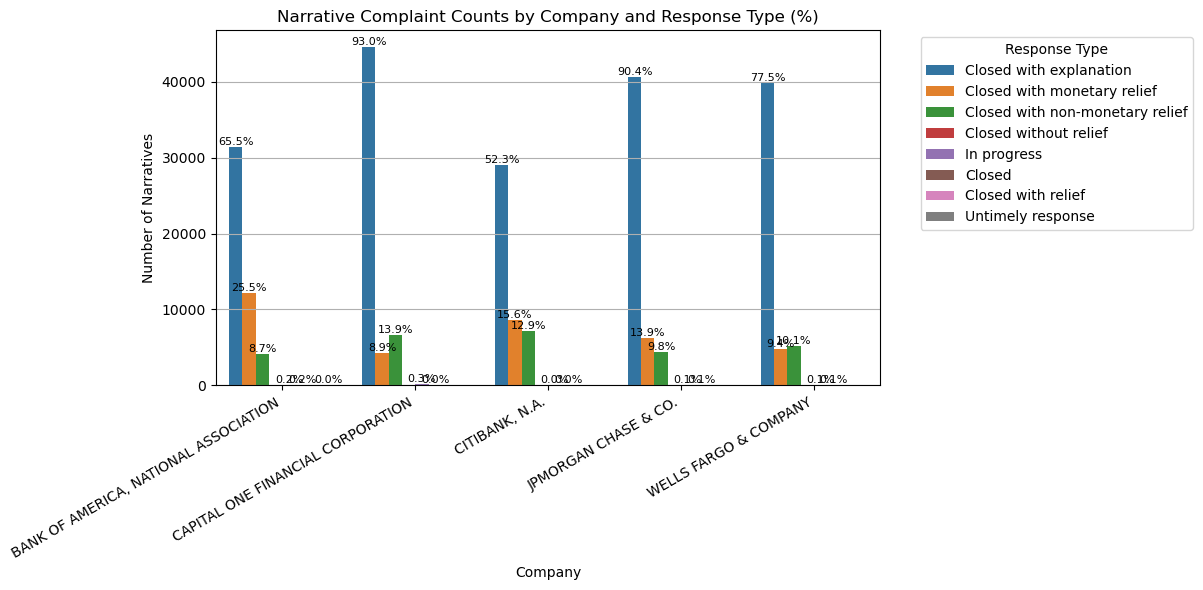

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new figure
plt.figure(figsize=(12, 6))

# Plot bar chart
ax = sns.barplot(
    data=grouped,
    x='company',
    y='narrative_count',
    hue='company_response_to_consumer',
    palette='tab10'
)

# Add % labels on top of each bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            # Get corresponding company and response type from bar position
            x_pos = bar.get_x() + bar.get_width() / 2
            bar_index = list(ax.containers).index(container)
            bar_label = bar.get_label()  # the response type
            company_label = ax.get_xticklabels()[int(x_pos)].get_text()

            # Get total narrative count for this company
            total_narratives = grouped[grouped['company'] == company_label]['narrative_count'].sum()
            pct = (height / total_narratives) * 100

            # Annotate
            ax.annotate(f"{pct:.1f}%",
                        (bar.get_x() + bar.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=8, color='black', rotation=0)

# Final touches
plt.xticks(rotation=30, ha='right')
plt.xlabel("Company")
plt.ylabel("Number of Narratives")
plt.title("Narrative Complaint Counts by Company and Response Type (%)")
plt.legend(title="Response Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

### Step 4: Baseline Model

### Step 4: Filter to Three Key Response Categories

We narrow our master dataset down to only the three “closed” categories we care about:

- **Closed with explanation**  
- **Closed with monetary relief**  
- **Closed with non-monetary relief**  

All other response types are dropped as noise.

In [5]:
# Step 4: Keep only the 3 desired response categories
keep_responses = [
    'Closed with explanation',
    'Closed with monetary relief',
    'Closed with non-monetary relief'
]

df_filtered = df_banks[
    df_banks['company_response_to_consumer'].isin(keep_responses)
].copy()

print("After filtering, dataset shape:", df_filtered.shape)
print("Remaining response types:\n", 
      df_filtered['company_response_to_consumer'].value_counts())

After filtering, dataset shape: (652651, 18)
Remaining response types:
 company_response_to_consumer
Closed with explanation            496590
Closed with monetary relief         83535
Closed with non-monetary relief     72526
Name: count, dtype: int64


### Step 5: Create Binary Target for Monetary Relief

We convert the three categories into a **binary target**:
- **1** if “Closed with monetary relief”  
- **0** otherwise (i.e. “Closed with explanation” or “Closed with non-monetary relief”)

In [6]:
df_filtered['monetary_relief'] = np.where(
    df_filtered['company_response_to_consumer'] == 'Closed with monetary relief',
    1,
    0
)

print("Value counts for target 'monetary_relief':\n",
      df_filtered['monetary_relief'].value_counts())

Value counts for target 'monetary_relief':
 monetary_relief
0    569116
1     83535
Name: count, dtype: int64


### Step 6: Select Features and One-Hot Encode

We will use the categorical attributes:
- **product**  
- **sub-product**  
- **issue**  
- **sub-issue**

We one-hot encode these four columns to prepare for a baseline classifier.

In [7]:
# Select our features and the target
features = ['product', 'sub-product', 'issue', 'sub-issue']
X_cat = df_filtered[features]
y = df_filtered['monetary_relief']

# One-hot encode
X = pd.get_dummies(X_cat, drop_first=True)

print("Feature matrix shape after one-hot encoding:", X.shape)

Feature matrix shape after one-hot encoding: (652651, 535)


### Step 7: Train/Test Split

We split our data into 80% train / 20% test sets, stratifying on the target to preserve class balance.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target balance:\n", y_train.value_counts(normalize=True))
print("Test  target balance:\n", y_test.value_counts(normalize=True))

Train shape: (522120, 535) Test shape: (130531, 535)
Train target balance:
 monetary_relief
0    0.872006
1    0.127994
Name: proportion, dtype: float64
Test  target balance:
 monetary_relief
0    0.872007
1    0.127993
Name: proportion, dtype: float64


### Step 8: Baseline Model — Logistic Regression

We fit a simple logistic regression as our baseline classifier and evaluate accuracy, precision, recall, and F1 on the test set.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Predict & evaluate
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.8726279581095678

Classification Report:
               precision    recall  f1-score   support

           0     0.8742    0.9975    0.9318    113824
           1     0.5628    0.0217    0.0418     16707

    accuracy                         0.8726    130531
   macro avg     0.7185    0.5096    0.4868    130531
weighted avg     0.8343    0.8726    0.8179    130531



### Step 9: Address Class Imbalance

Our baseline logistic regression almost always predicts the majority class (no monetary relief), so recall on the minority (“monetary relief”) is only ~2 %. We’ll try two strategies:

1. **Class‐weighted logistic regression** – tell the model to “pay more attention” to the minority class.  
2. **SMOTE oversampling + logistic regression** – synthetically increase minority samples in the training set.
3. **Random Under-Sampling** - to Balance Classes

We’ll compare precision, recall, and F1 for each approach.

In [10]:
# 9a. LogisticRegression with class_weight='balanced'

clf_bal = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf_bal.fit(X_train, y_train)
y_pred_bal = clf_bal.predict(X_test)

print("=== Class‐Weighted LR ===")
print("Accuracy:", accuracy_score(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal, digits=4))

=== Class‐Weighted LR ===
Accuracy: 0.6588703066704461
              precision    recall  f1-score   support

           0     0.9577    0.6369    0.7651    113824
           1     0.2463    0.8083    0.3776     16707

    accuracy                         0.6589    130531
   macro avg     0.6020    0.7226    0.5713    130531
weighted avg     0.8666    0.6589    0.7155    130531



In [11]:
# 9b. SMOTE oversampling + LogisticRegression
from imblearn.over_sampling import SMOTE

# Ensure all features are numeric (float)
X_train_num = X_train.astype(float)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_num.values, y_train)

print("After SMOTE, shapes:", X_res.shape, y_res.shape)

# Train logistic regression on the resampled data

clf_sm = LogisticRegression(max_iter=1000, random_state=42)
clf_sm.fit(X_res, y_res)
y_pred_sm = clf_sm.predict(X_test.astype(float).values)

print("=== SMOTE + LR ===")
print("Accuracy:", accuracy_score(y_test, y_pred_sm))
print(classification_report(y_test, y_pred_sm, digits=4))

After SMOTE, shapes: (910584, 535) (910584,)
=== SMOTE + LR ===
Accuracy: 0.6589698998705288
              precision    recall  f1-score   support

           0     0.9576    0.6371    0.7652    113824
           1     0.2463    0.8079    0.3775     16707

    accuracy                         0.6590    130531
   macro avg     0.6019    0.7225    0.5713    130531
weighted avg     0.8666    0.6590    0.7155    130531



In [12]:
# 9c: Random Under-Sampling to Balance Classes
from sklearn.utils import resample

# Separate majority and minority classes
X_train_pos = X_train[y_train == 1]
X_train_neg = X_train[y_train == 0]

# Down-sample majority class
X_neg_down = resample(
    X_train_neg,
    replace=False,
    n_samples=len(X_train_pos),
    random_state=42
)

# Create balanced training set
X_bal = pd.concat([X_train_pos, X_neg_down])
y_bal = pd.concat([
    y_train[y_train == 1],
    y_train.loc[X_neg_down.index]
])

print("Balanced train shape:", X_bal.shape, y_bal.value_counts())

# Train logistic regression on the balanced set
clf_under = LogisticRegression(max_iter=1000, random_state=42)
clf_under.fit(X_bal, y_bal)

# Evaluate on the original test set
y_pred_under = clf_under.predict(X_test)

print("=== Under-Sampling + LR ===")
print("Accuracy:", accuracy_score(y_test, y_pred_under))
print(classification_report(y_test, y_pred_under, digits=4))

Balanced train shape: (133656, 535) monetary_relief
1    66828
0    66828
Name: count, dtype: int64
=== Under-Sampling + LR ===
Accuracy: 0.6584489508239422
              precision    recall  f1-score   support

           0     0.9577    0.6364    0.7647    113824
           1     0.2461    0.8086    0.3773     16707

    accuracy                         0.6584    130531
   macro avg     0.6019    0.7225    0.5710    130531
weighted avg     0.8666    0.6584    0.7151    130531



Our under-sampling approach yields nearly identical performance to class-weighting and SMOTE:
- Recall on “monetary relief” is around 80.8 %, matching the others.
- Precision on “monetary relief” remains low (~24.6 %).
- Overall accuracy is ~65.8 %, again in line with the other methods.

Interpretation
All three imbalance strategies (class‐weighting, SMOTE, under‐sampling) have similar effect: they force the model to catch the majority of monetary‐relief cases (high recall) at the expense of many false positives (low precision). Under‐sampling discards a lot of “no relief” data to balance classes, but the learned boundary and test performance don’t change much.
